# Data and Constants

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from pycaret.regression import *

In [2]:
lipid_path = 'data/lba_all_pixels_fully_abamapped11062023-001.h5'
gene_path = 'data/cell_filtered_w500genes-002.h5'

# Loading Dataset

In [3]:
# Loading the dataset
lipids = pd.read_hdf(lipid_path)
genes = pd.read_hdf(gene_path)

# Basic Preprocessing

In [4]:
lipids_exponential = lipids.copy()

# Fill in background pixels and exponential (the data we imported were logged, you can play with both scales)
lipids_exponential = lipids_exponential.fillna(-9.21)
lipids_exponential.iloc[:,3:205] = np.exp(lipids_exponential.iloc[:,3:205].values)

In [5]:
# Select section 12
lipids_section_12 = lipids_exponential.loc[lipids['Section'] == 12]

genes_section_12 = genes.loc[(genes['x_ccf'] > 7.4) & (genes['x_ccf'] < 7.8), :]


# K neighbors mean of genes for a given lipids datapoint

In [6]:
def exponential_decay(distance, threshold, decay_rate):
    adjusted_distance = distance - threshold
    return np.exp(-decay_rate * adjusted_distance)

In [30]:
# Create a KDTree object for the genes
genes_coords = genes_section_12[['y_ccf', 'z_ccf']].values
genes_kdtree = cKDTree(genes_coords)

# Extract coordinates from section_12 for lipids
lipids_coords = lipids_section_12[['y_ccf', 'z_ccf']].values

# Find the distances and indices of the closest gene for each lipid point
distances, indices = genes_kdtree.query(lipids_coords, k=3)

# Calculate the average distance of the closest neighbors
average_closest_distance = np.mean(distances)

# Re-query to get the 10 closest genes and their distances
distances, indices = genes_kdtree.query(lipids_coords, k=100)

# Initialize an empty array for aggregated gene data
aggregated_gene_data = np.zeros((len(lipids_coords), genes_section_12.iloc[:, 46:-50].shape[1]))

# Perform weighted aggregation
for i, (gene_indices, dists) in enumerate(zip(indices, distances)):
    # Weights based on distance, with a penalty for distances greater than the average closest distance
    weights = np.where(dists <= average_closest_distance, 1, exponential_decay(dists, average_closest_distance, 0.5))  # Apply penalty for dist > average_closest_distance
    weighted_data = genes_section_12.iloc[gene_indices, 46:-50] * weights[:, np.newaxis]
    aggregated_gene_data[i] = weighted_data.sum(axis=0) / weights.sum() if weights.sum() > 0 else np.zeros(genes_section_12.iloc[:, 46:-50].shape[1])

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=genes_section_12.columns[46:-50])

In [31]:
aggregated_gene_data_df

,ENSMUST00000028118,ENSMUST00000028280,ENSMUST00000030676,ENSMUST00000047328,ENSMUST00000057021,ENSMUST00000090697,ENSMUST00000091554,ENSMUST00000162772,ENSMUST00000021284,ENSMUST00000022195,...,ENSMUST00000109964,ENSMUST00000114553,ENSMUST00000152412,ENSMUST00000159365,ENSMUST00000175965,ENSMUST00000196378,ENSMUST00000228095,ENSMUST00000000219,ENSMUST00000035577,ENSMUST00000060943
0,0.205801,0.515053,0.142261,1.232951,0.516153,0.073602,0.050121,0.085055,0.706085,0.069639,...,0.015670,0.017111,0.020765,0.337501,0.000000,0.403568,0.012492,0.021588,0.036356,0.000000
1,0.205771,0.543110,0.142272,1.242489,0.523815,0.073806,0.050146,0.092083,0.713747,0.069465,...,0.015665,0.017082,0.020824,0.334513,0.006830,0.451137,0.020944,0.008334,0.036378,0.000000
2,0.213981,0.523904,0.150671,1.121466,0.463245,0.061605,0.050128,0.092257,0.682711,0.069203,...,0.015631,0.008059,0.020870,0.320208,0.006871,0.461561,0.008549,0.008300,0.036379,0.000000
3,0.211602,0.493729,0.166843,1.143477,0.447616,0.071017,0.048590,0.080967,0.681780,0.053484,...,0.015569,0.008119,0.030151,0.364231,0.006909,0.489796,0.008589,0.008257,0.042400,0.007402
4,0.157447,0.530368,0.121682,1.170183,0.473682,0.077421,0.040176,0.081125,0.664573,0.049165,...,0.008496,0.008177,0.021769,0.391669,0.006944,0.511047,0.008622,0.017138,0.042567,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94742,0.231690,0.753681,0.334804,1.338283,0.764494,0.091073,0.253148,0.101492,0.900037,0.030515,...,0.018272,0.069894,0.008287,0.148934,0.027737,0.291651,0.008653,0.039055,0.029729,0.000000
94743,0.247521,0.707288,0.357918,1.342079,0.739526,0.075325,0.238914,0.090719,0.883575,0.024337,...,0.018273,0.069866,0.008233,0.159271,0.042320,0.282834,0.008647,0.038949,0.029766,0.000000
94744,0.260387,0.750756,0.380130,1.297182,0.712578,0.076229,0.245907,0.113308,0.882071,0.018373,...,0.018266,0.069806,0.008183,0.167271,0.042378,0.240559,0.008638,0.038838,0.042471,0.000000
94745,0.275399,0.724808,0.428453,1.238564,0.681472,0.076178,0.261076,0.122569,0.857879,0.018402,...,0.018255,0.053658,0.009059,0.167517,0.054144,0.246591,0.008628,0.028493,0.042569,0.000000


In [32]:
section_12_lipids_only = lipids_section_12.iloc[:, 3:-3]
section_12_lipids_only

,LPC O-16:2,LPC 16:0_dup,LPC O- 18:3,LPC O-18:2,LPC O-16:2_dup,LPC 15:1,LPC 18:1,LPC 18:0_dup,LPC 16:0,LPC O-18:3,...,SM(t42:1),PC(40:7),PC 40:6_dup,PG(42:6),Hex2Cer 32:0,SHexCer 38:1;3,PE(44:11(OH)),PC(40:4),PS(40:4),PIP(O-36:5)
section12_pixel23_121,0.000140,0.000112,0.000116,0.000125,0.000214,0.000100,0.0001,0.000197,0.000179,0.0001,...,0.0001,0.000100,0.000241,0.000179,0.0001,0.000100,0.0001,0.000261,0.0001,0.000360
section12_pixel23_122,0.000213,0.000112,0.000114,0.000125,0.000204,0.000162,0.0001,0.000100,0.000181,0.0001,...,0.0001,0.000114,0.000395,0.000208,0.0001,0.000316,0.0001,0.000268,0.0001,0.000100
section12_pixel23_123,0.000154,0.000100,0.000117,0.000134,0.000195,0.000151,0.0001,0.000232,0.000179,0.0001,...,0.0001,0.000114,0.000233,0.000203,0.0001,0.000100,0.0001,0.000232,0.0001,0.000100
section12_pixel23_124,0.000147,0.000113,0.000114,0.000136,0.000229,0.000154,0.0001,0.000100,0.000120,0.0001,...,0.0001,0.000114,0.000285,0.000187,0.0001,0.000255,0.0001,0.000100,0.0001,0.000366
section12_pixel23_125,0.000229,0.000112,0.000115,0.000206,0.000100,0.000100,0.0001,0.000100,0.000122,0.0001,...,0.0001,0.000100,0.000247,0.000179,0.0001,0.000323,0.0001,0.000100,0.0001,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
section12_pixel308_157,0.000139,0.000100,0.000100,0.000100,0.000100,0.000100,0.0001,0.000100,0.000100,0.0001,...,0.0001,0.000100,0.000100,0.000100,0.0001,0.000100,0.0001,0.000100,0.0001,0.000100
section12_pixel308_158,0.000139,0.000100,0.000100,0.000100,0.000100,0.000100,0.0001,0.000100,0.000119,0.0001,...,0.0001,0.000100,0.000100,0.000100,0.0001,0.000100,0.0001,0.000100,0.0001,0.000100
section12_pixel308_159,0.000155,0.000112,0.000117,0.000100,0.000100,0.000100,0.0001,0.000100,0.000100,0.0001,...,0.0001,0.000100,0.000100,0.000100,0.0001,0.000100,0.0001,0.000100,0.0001,0.000100
section12_pixel308_160,0.000141,0.000113,0.000100,0.000100,0.000100,0.000100,0.0001,0.000237,0.000119,0.0001,...,0.0001,0.000100,0.000100,0.000100,0.0001,0.000100,0.0001,0.000100,0.0001,0.000100


In [33]:
aggregated_gene_data_df = aggregated_gene_data_df.reset_index(drop=True)
section_12_lipids_only = section_12_lipids_only.reset_index(drop=True)

# Simplify lipid names

In [34]:
def rename_lipid(lipid_name):
    # Example renaming scheme - customize as needed
    new_name = lipid_name.replace(':', ';').replace('\xa0', ' ')
    return new_name

section_12_lipids_only.columns = [rename_lipid(lipid) for lipid in section_12_lipids_only.columns] 

# Selecting best model and training it and see the results

In [35]:
list_models = ['lr', 'ridge', 'catboost', 'br']

# Loop through each lipid type based on the lipid names in the column headers.
for i, lipid_name in enumerate(section_12_lipids_only.columns):
    
    # Create a DataFrame to store genes and the corresponding lipid values
    # Use the aggregated gene data (aggregated_gene_data_df) and the lipid data
    df = aggregated_gene_data_df.copy()
    
    # Add a column for the lipid values
    # The index should match the index of the aggregated gene data
    df[lipid_name] = section_12_lipids_only.iloc[:, i]
    
    # Step 1: Setup the environment in PyCaret
    setup(data=df, session_id=42, use_gpu=True)

    # Step 2: Compare models dynamically
    best_model = compare_models(include=list_models)

    # Step 3: Create the model
    model = create_model(best_model)

    # Step 4: Finalize the model
    final_model = finalize_model(model)
    
    # Step 5: Save the model
    save_model(final_model, f'models/{lipid_name}_model_{i}')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,LPC O-16;2
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0002,0.0000,0.0003,0.6091,0.0003,0.2828,3.7010
ridge,Ridge Regression,0.0003,0.0000,0.0004,0.4593,0.0004,0.3774,0.5210
br,Bayesian Ridge,0.0003,0.0000,0.0004,0.4593,0.0004,0.3785,1.2920
lr,Linear Regression,0.0003,0.0000,0.0004,0.4592,0.0004,0.3773,1.0590


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0002,0.0000,0.0003,0.6156,0.0003,0.2903
1,0.0002,0.0000,0.0003,0.6172,0.0003,0.2826
2,0.0002,0.0000,0.0003,0.6033,0.0003,0.2816
3,0.0002,0.0000,0.0003,0.6023,0.0003,0.2901
4,0.0002,0.0000,0.0003,0.6085,0.0003,0.2802
5,0.0002,0.0000,0.0003,0.6036,0.0003,0.2785
6,0.0002,0.0000,0.0003,0.6065,0.0003,0.2831
7,0.0002,0.0000,0.0003,0.6113,0.0003,0.2817
8,0.0003,0.0000,0.0003,0.6146,0.0003,0.2823


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC 16;0_dup
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0002,0.2242,0.0002,0.3295,3.6530
br,Bayesian Ridge,0.0001,0.0000,0.0002,0.1299,0.0002,0.3655,1.2020
ridge,Ridge Regression,0.0001,0.0000,0.0002,0.1295,0.0002,0.3652,0.5250
lr,Linear Regression,0.0001,0.0000,0.0002,0.1294,0.0002,0.3652,1.0310


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0002,0.2426,0.0002,0.3307
1,0.0001,0.0000,0.0002,0.2131,0.0002,0.3336
2,0.0001,0.0000,0.0002,0.2170,0.0002,0.3321
3,0.0001,0.0000,0.0002,0.2177,0.0002,0.3331
4,0.0001,0.0000,0.0002,0.2271,0.0002,0.3239
5,0.0001,0.0000,0.0002,0.2250,0.0002,0.3325
6,0.0001,0.0000,0.0002,0.2250,0.0002,0.3306
7,0.0001,0.0000,0.0002,0.2397,0.0002,0.3279
8,0.0001,0.0000,0.0002,0.2177,0.0002,0.3295


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC O- 18;3
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0002,0.3942,0.0002,0.2727,3.6590
br,Bayesian Ridge,0.0001,0.0000,0.0002,0.2692,0.0002,0.3292,1.1940
ridge,Ridge Regression,0.0001,0.0000,0.0002,0.2690,0.0002,0.3288,0.5200
lr,Linear Regression,0.0001,0.0000,0.0002,0.2689,0.0002,0.3287,1.0380


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0002,0.4141,0.0002,0.2725
1,0.0001,0.0000,0.0002,0.4057,0.0002,0.2750
2,0.0001,0.0000,0.0002,0.3909,0.0002,0.2672
3,0.0001,0.0000,0.0002,0.3804,0.0002,0.2849
4,0.0001,0.0000,0.0002,0.3880,0.0002,0.2695
5,0.0001,0.0000,0.0002,0.3797,0.0002,0.2683
6,0.0001,0.0000,0.0002,0.3863,0.0002,0.2748
7,0.0001,0.0000,0.0002,0.4023,0.0002,0.2722
8,0.0001,0.0000,0.0002,0.3902,0.0002,0.2745


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC O-18;2
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0001,0.3544,0.0001,0.2532,3.6400
br,Bayesian Ridge,0.0001,0.0000,0.0002,0.2068,0.0002,0.2968,1.3360
ridge,Ridge Regression,0.0001,0.0000,0.0002,0.2065,0.0002,0.2967,0.5150
lr,Linear Regression,0.0001,0.0000,0.0002,0.2064,0.0002,0.2966,1.0880


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0001,0.3775,0.0001,0.2587
1,0.0001,0.0000,0.0001,0.3577,0.0001,0.2524
2,0.0001,0.0000,0.0001,0.3469,0.0001,0.2491
3,0.0001,0.0000,0.0001,0.3262,0.0001,0.2605
4,0.0001,0.0000,0.0001,0.3600,0.0001,0.2455
5,0.0001,0.0000,0.0001,0.3352,0.0001,0.2529
6,0.0001,0.0000,0.0001,0.3583,0.0001,0.2477
7,0.0001,0.0000,0.0001,0.3611,0.0001,0.2517
8,0.0001,0.0000,0.0001,0.3508,0.0001,0.2546


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC O-16;2_dup
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0001,0.5412,0.0001,0.2632,3.6300
br,Bayesian Ridge,0.0001,0.0000,0.0001,0.4370,0.0001,0.3145,1.2090
lr,Linear Regression,0.0001,0.0000,0.0001,0.4369,0.0001,0.3142,1.0280
ridge,Ridge Regression,0.0001,0.0000,0.0001,0.4369,0.0001,0.3143,0.5200


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0001,0.5477,0.0001,0.2659
1,0.0001,0.0000,0.0001,0.5394,0.0001,0.2631
2,0.0001,0.0000,0.0001,0.5343,0.0001,0.2593
3,0.0001,0.0000,0.0001,0.5474,0.0001,0.2582
4,0.0001,0.0000,0.0001,0.5490,0.0001,0.2673
5,0.0001,0.0000,0.0001,0.5361,0.0001,0.2614
6,0.0001,0.0000,0.0001,0.5437,0.0001,0.2637
7,0.0001,0.0000,0.0001,0.5430,0.0001,0.2641
8,0.0001,0.0000,0.0001,0.5371,0.0001,0.2620


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC 15;1
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0004,0.0000,0.0006,0.7740,0.0006,0.5129,3.5310
ridge,Ridge Regression,0.0005,0.0000,0.0008,0.5886,0.0008,0.9742,0.5210
lr,Linear Regression,0.0005,0.0000,0.0008,0.5885,0.0008,0.9757,1.0180
br,Bayesian Ridge,0.0005,0.0000,0.0008,0.5885,0.0008,0.9686,1.1800


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0004,0.0000,0.0006,0.7790,0.0006,0.5214
1,0.0004,0.0000,0.0006,0.7859,0.0006,0.5031
2,0.0004,0.0000,0.0006,0.7569,0.0006,0.5213
3,0.0004,0.0000,0.0006,0.7689,0.0006,0.5184
4,0.0004,0.0000,0.0006,0.7716,0.0006,0.5104
5,0.0004,0.0000,0.0006,0.7728,0.0006,0.5242
6,0.0004,0.0000,0.0006,0.7607,0.0006,0.5128
7,0.0004,0.0000,0.0006,0.7840,0.0006,0.4965
8,0.0004,0.0000,0.0006,0.7810,0.0006,0.5025


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC 18;1
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0002,0.3517,0.0002,0.3128,3.7260
br,Bayesian Ridge,0.0001,0.0000,0.0002,0.2805,0.0002,0.3437,1.2450
ridge,Ridge Regression,0.0001,0.0000,0.0002,0.2802,0.0002,0.3435,0.5170
lr,Linear Regression,0.0001,0.0000,0.0002,0.2801,0.0002,0.3434,1.0300


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0002,0.3591,0.0002,0.3166
1,0.0001,0.0000,0.0002,0.3541,0.0002,0.3133
2,0.0001,0.0000,0.0002,0.3419,0.0002,0.3183
3,0.0001,0.0000,0.0002,0.3342,0.0002,0.3218
4,0.0001,0.0000,0.0002,0.3532,0.0002,0.3110
5,0.0001,0.0000,0.0002,0.3567,0.0002,0.3113
6,0.0001,0.0000,0.0002,0.3567,0.0002,0.3128
7,0.0001,0.0000,0.0002,0.3687,0.0002,0.3032
8,0.0001,0.0000,0.0002,0.3398,0.0002,0.3092


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC 18;0_dup
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0001,0.0000,0.0002,0.3155,0.0002,0.3236,3.7280
br,Bayesian Ridge,0.0001,0.0000,0.0002,0.2222,0.0002,0.3532,1.1740
ridge,Ridge Regression,0.0001,0.0000,0.0002,0.2220,0.0002,0.3531,0.5170
lr,Linear Regression,0.0001,0.0000,0.0002,0.2219,0.0002,0.3531,1.0540


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0002,0.3262,0.0002,0.3305
1,0.0001,0.0000,0.0002,0.3244,0.0002,0.3266
2,0.0001,0.0000,0.0002,0.3017,0.0002,0.3283
3,0.0001,0.0000,0.0002,0.3086,0.0002,0.3303
4,0.0001,0.0000,0.0002,0.3066,0.0002,0.3182
5,0.0001,0.0000,0.0002,0.3178,0.0002,0.3176
6,0.0001,0.0000,0.0001,0.3072,0.0001,0.3203
7,0.0001,0.0000,0.0002,0.3339,0.0002,0.3227
8,0.0001,0.0000,0.0002,0.3140,0.0002,0.3231


Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] 

,Description,Value
0,Session id,42
1,Target,LPC 16;0
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0003,0.0000,0.0003,0.4896,0.0003,0.2897,3.5090
ridge,Ridge Regression,0.0003,0.0000,0.0004,0.3678,0.0004,0.3717,0.5180
br,Bayesian Ridge,0.0003,0.0000,0.0004,0.3678,0.0004,0.3734,1.1740
lr,Linear Regression,0.0003,0.0000,0.0004,0.3677,0.0004,0.3715,1.0130


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:46:44
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# Loading models, predict, and look at different metrics

Transformation Pipeline and Model Successfully Loaded


,Description,Value
0,Session id,42
1,Target,LPC O-16;2
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0002,0.0000,0.0003,0.6826,0.0003,0.2533


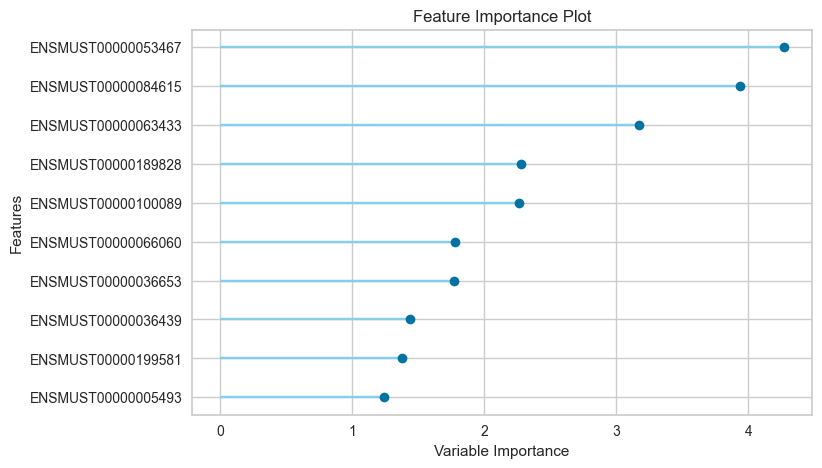

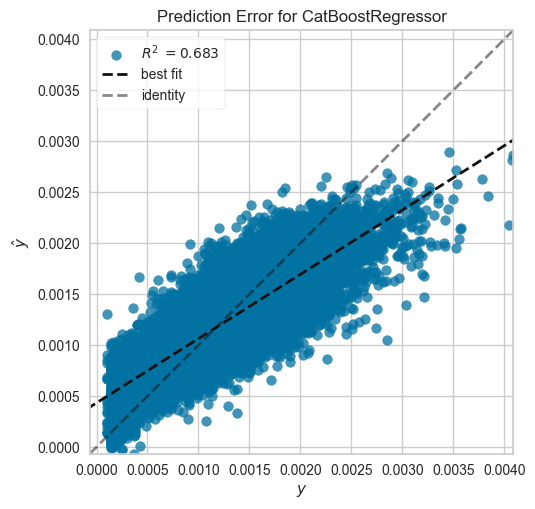

Transformation Pipeline and Model Successfully Loaded


,Description,Value
0,Session id,42
1,Target,LPC 16;0_dup
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0001,0.0000,0.0002,0.1206,0.0002,0.3765


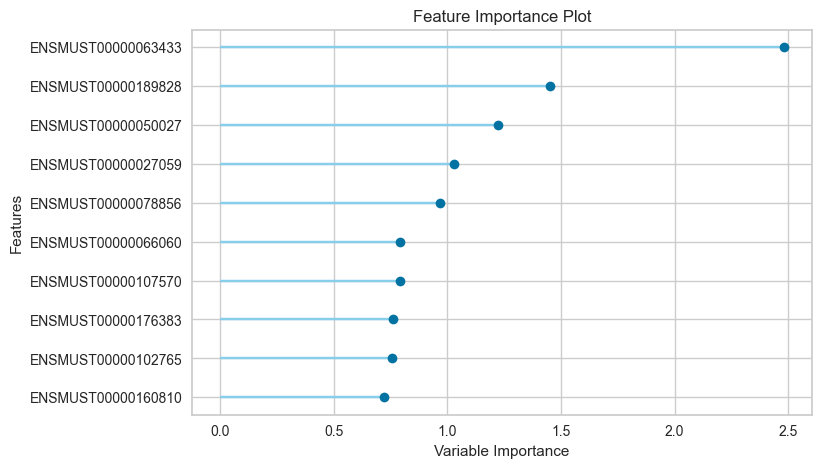

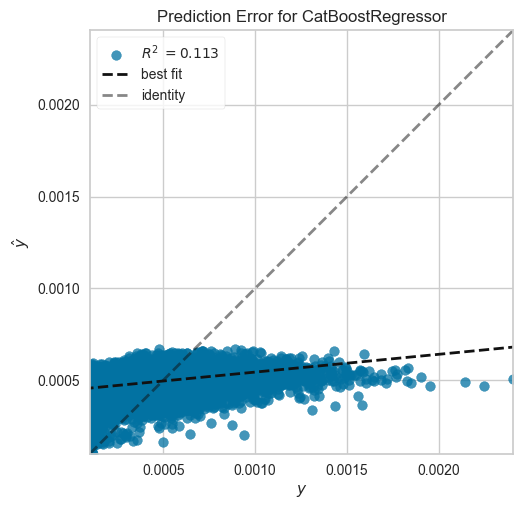

Transformation Pipeline and Model Successfully Loaded


,Description,Value
0,Session id,42
1,Target,LPC O- 18;3
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0001,0.0000,0.0002,0.2390,0.0002,0.3611


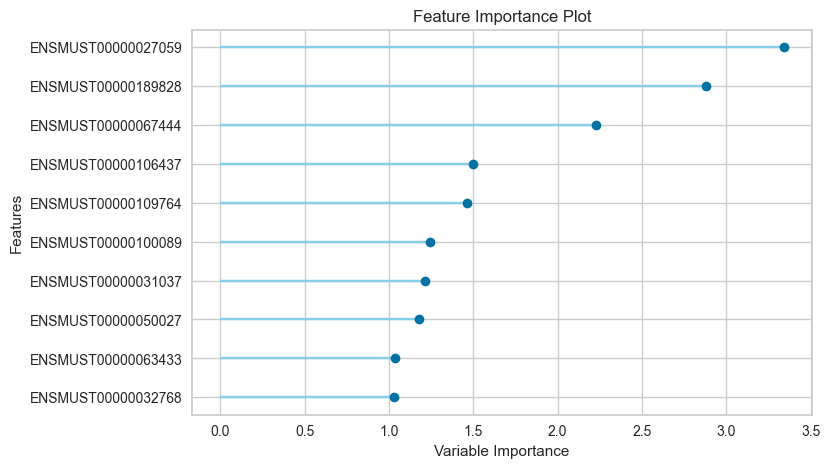

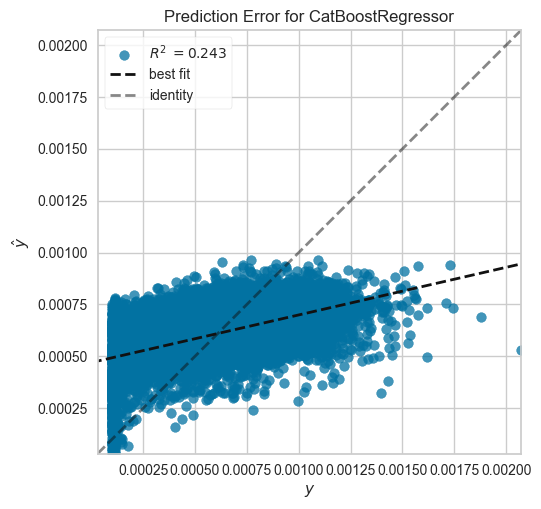

Transformation Pipeline and Model Successfully Loaded


,Description,Value
0,Session id,42
1,Target,LPC O-18;2
2,Target type,Regression
3,Original data shape,"(94747, 501)"
4,Transformed data shape,"(94747, 501)"
5,Transformed train set shape,"(66322, 501)"
6,Transformed test set shape,"(28425, 501)"
7,Numeric features,500
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0001,0.0000,0.0002,0.1873,0.0002,0.3119


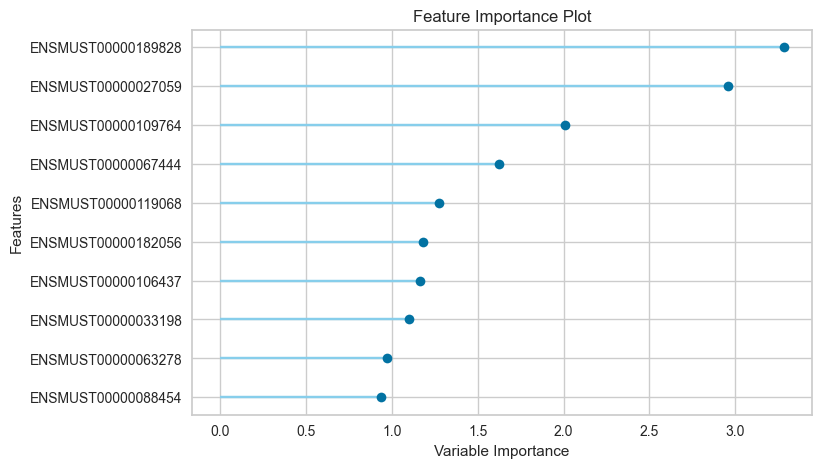

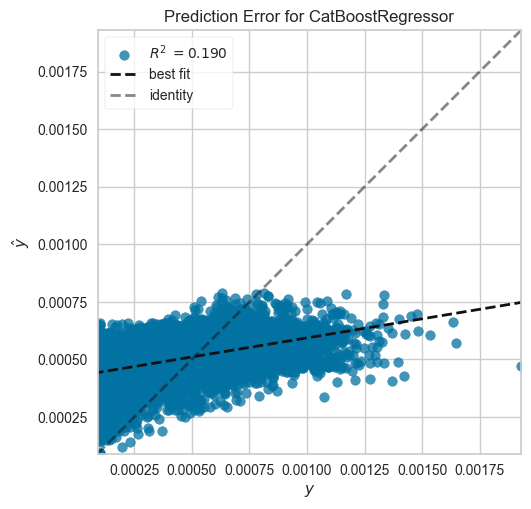

Transformation Pipeline and Model Successfully Loaded


KeyboardInterrupt: 

In [ ]:
for i, lipid_name in enumerate(section_12_lipids_only.columns):
    model_path = f'models/{lipid_name}_model_{i}'
    model = load_model(model_path)
    
    df = aggregated_gene_data_df.copy()
    df[lipid_name] = section_12_lipids_only.iloc[:, i]
    
    s = setup(data=df, session_id=42)
    
    predict_model(model, data=df)
    plot_model(model, plot='feature')
    plot_model(model, plot='error')